Rows after cleaning: 5319
Theme-year rows: 512
Themes with >=3 years: 57
Themes with valid slopes: 57
                  theme  slope_median  slope_max  slope_diff  slope_diff_abs
29                Icons -3.000000e+01  40.000000   70.000000       70.000000
44           Powered Up  6.800000e+00  61.000000   54.200000       54.200000
40         Nexo Knights  8.750000e+00 -30.000000  -38.750000       38.750000
34  Marvel Super Heroes  6.136364e-01  29.590909   28.977273       28.977273
51            Star Wars -6.208571e+00  22.540998   28.749568       28.749568
18           Dimensions -1.256074e-15 -27.500000  -27.500000       27.500000
28         Harry Potter -1.659483e+00  22.284483   23.943966       23.943966
30                Ideas  1.240909e+01  35.000000   22.590909       22.590909
33     Legends of Chima  7.500000e+00 -15.000000  -22.500000       22.500000
53              Technic  2.243550e+00  23.467492   21.223942       21.223942
Final ML dataset rows: 57


C:\Users\Colin Briggs\AppData\Local\Temp\ipykernel_27632\3212094710.py:98: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fit_price_trends)


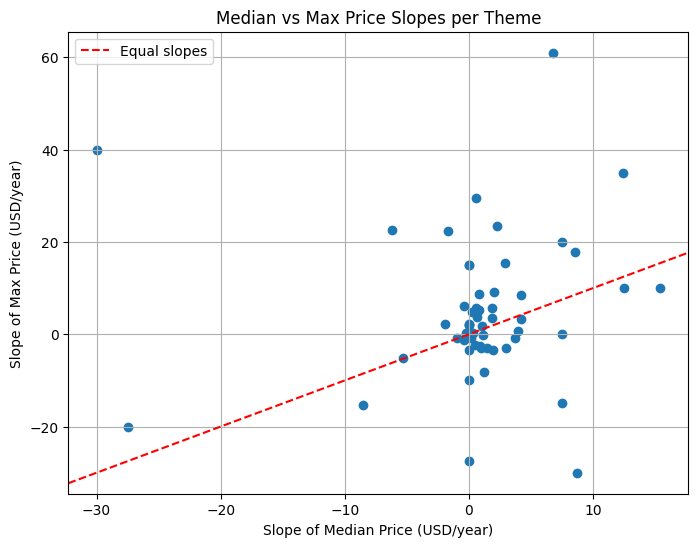

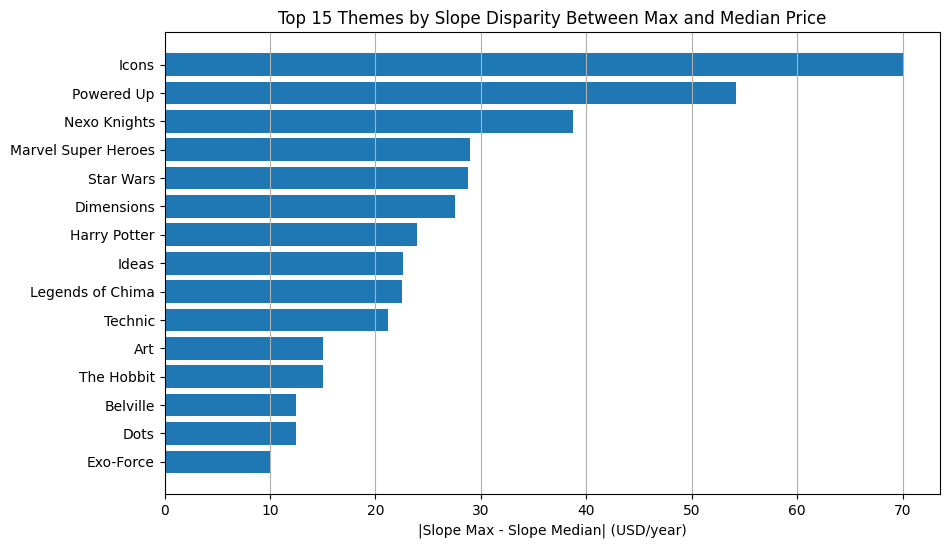

Feature matrix shape: (57, 23)
Target shape: (57,)
Train size: 39 Test size: 18

=== Linear Regression ===
MSE: 510.569
RMSE: 22.596
R^2: -8.403

=== Gradient Boosting Regressor ===
MSE: 128.773
RMSE: 11.348
R^2: -1.372

=== Linear Regression K-Fold (5 folds) ===
Mean R^2: -1.915 | Std: 1.991
Mean RMSE: 17.992 | Std: 7.109

=== Gradient Boosting K-Fold (5 folds) ===
Mean R^2: -0.558 | Std: 0.544
Mean RMSE: 13.974 | Std: 5.588

=== Linear Regression LOOCV ===
Mean R^2: nan
Std R^2: nan

Top 15 features by importance (Gradient Boosting):
                          feature  importance
2                       avg_price    0.326140
0                      avg_pieces    0.244472
3            median_price_overall    0.169397
4                      total_sets    0.091822
7                      span_years    0.074291
1                    avg_minifigs    0.055526
6                       last_year    0.013878
5                      first_year    0.009305
12          themeGroup_mode_Girls    0.00584

c:\Users\Colin Briggs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Colin Briggs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Colin Briggs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Colin Briggs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Colin Briggs\Ap

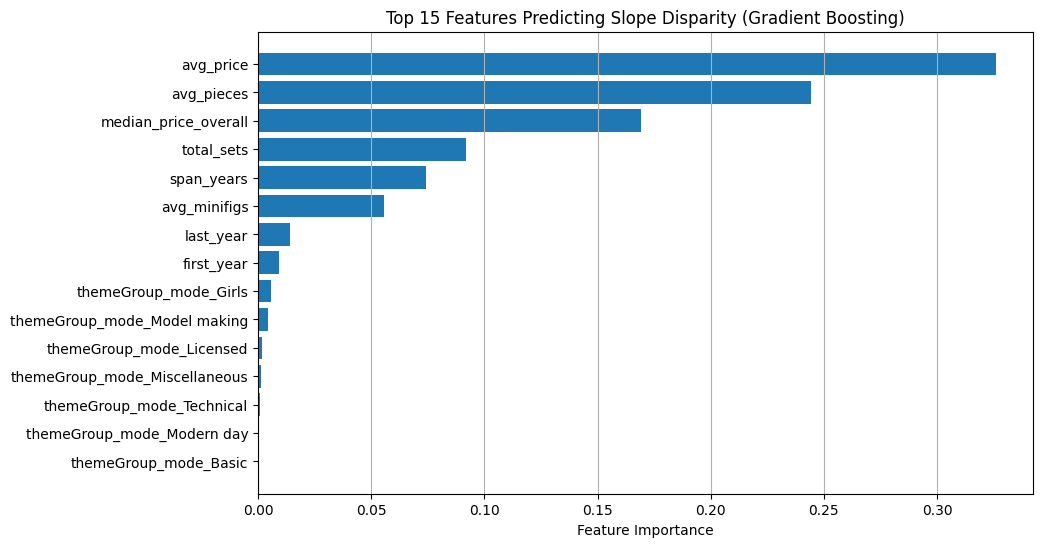

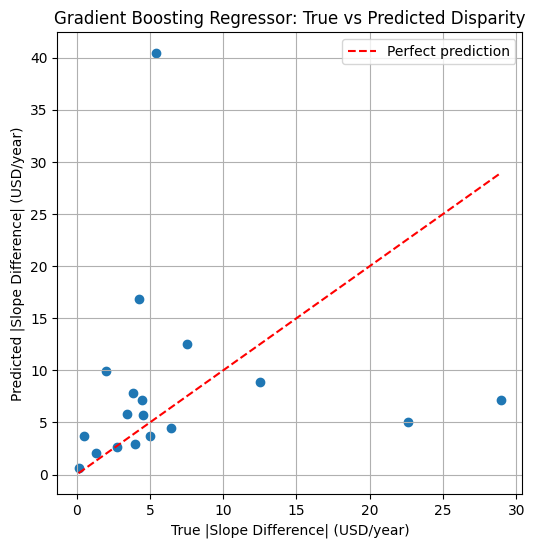

In [ ]:
# AI Disclaimer: ChatGPT assisted with syntax only; analysis and interpretation are my own.

# %%
#imports
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

#allow_altair_big_data
alt.data_transformers.disable_max_rows()

# %%
#load_data
csv_path = r"C:\Users\Colin Briggs\Downloads\lego_filtered.csv"
df = pd.read_csv(csv_path)

#basic_cleaning
df = df.copy()
df = df.dropna(subset=["US_retailPrice", "year"])
df["year"] = df["year"].astype(int)
df = df[df["US_retailPrice"] > 0]

print("Rows after cleaning:", len(df))

# %%
#aggregate_theme_year_stats
theme_year = (
    df.groupby(["theme", "year"])
      .agg(
          median_price=("US_retailPrice", "median"),
          max_price=("US_retailPrice", "max"),
          mean_price=("US_retailPrice", "mean"),
          n_sets=("set_id", "count"),
          median_pieces=("pieces", "median"),
          median_minifigs=("minifigs", "median")
      )
      .reset_index()
)

print("Theme-year rows:", len(theme_year))

# %%
#filter_themes_with_enough_years
theme_year_counts = theme_year.groupby("theme")["year"].nunique()
valid_themes = theme_year_counts[theme_year_counts >= 3].index.tolist()

theme_year_valid = theme_year[theme_year["theme"].isin(valid_themes)].copy()
print("Themes with >=3 years:", len(valid_themes))

# %%
#compute_slopes_per_theme
def fit_price_trends(group):
    years = group["year"].values
    med = group["median_price"].values
    mx = group["max_price"].values

    #scale_years
    year0 = years.mean()
    x = years - year0

    if len(group) < 2 or np.var(x) == 0:
        return pd.Series({
            "slope_median": np.nan,
            "intercept_median": np.nan,
            "slope_max": np.nan,
            "intercept_max": np.nan,
            "year_center": year0
        })

    #median regression
    b1_med, b0_med = np.polyfit(x, med, 1)
    #max regression
    b1_max, b0_max = np.polyfit(x, mx, 1)

    slope_median = b1_med
    intercept_median = b0_med - b1_med * year0

    slope_max = b1_max
    intercept_max = b0_max - b1_max * year0

    return pd.Series({
        "slope_median": slope_median,
        "intercept_median": intercept_median,
        "slope_max": slope_max,
        "intercept_max": intercept_max,
        "year_center": year0
    })

slopes = (
    theme_year_valid
    .groupby("theme")
    .apply(fit_price_trends)
    .reset_index()
)

#drop_missing_slopes
slopes = slopes.dropna(subset=["slope_median", "slope_max"])
print("Themes with valid slopes:", len(slopes))

# %%
#compute_disparity_target
slopes["slope_diff"] = slopes["slope_max"] - slopes["slope_median"]
slopes["slope_diff_abs"] = slopes["slope_diff"].abs()

#sort_by_disparity
print(slopes.sort_values("slope_diff_abs", ascending=False)[[
    "theme","slope_median","slope_max","slope_diff","slope_diff_abs"
]].head(10))

# %%
#build_theme_level_features
theme_features = (
    df.groupby("theme")
      .agg(
          themeGroup_mode=("themeGroup", lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else "Unknown"),
          category_mode=("category", lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else "Unknown"),
          avg_pieces=("pieces", "mean"),
          avg_minifigs=("minifigs", "mean"),
          avg_price=("US_retailPrice", "mean"),
          median_price_overall=("US_retailPrice", "median"),
          total_sets=("set_id", "count"),
          first_year=("year", "min"),
          last_year=("year", "max"),
          span_years=("year", lambda s: s.max() - s.min())
      )
      .reset_index()
)

# %%
#merge_slopes_and_features
data = slopes.merge(theme_features, on="theme", how="inner")
print("Final ML dataset rows:", len(data))

# %%
#quick_visualization_slopes_scatter
plt.figure(figsize=(8, 6))
plt.scatter(data["slope_median"], data["slope_max"])
plt.axline((0, 0), slope=1, color="red", linestyle="--", label="Equal slopes")
plt.xlabel("Slope of Median Price (USD/year)")
plt.ylabel("Slope of Max Price (USD/year)")
plt.title("Median vs Max Price Slopes per Theme")
plt.legend()
plt.grid(True)
plt.show()

# %%
#visualize_disparity_top_themes
top_disparity = data.sort_values("slope_diff_abs", ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(top_disparity["theme"], top_disparity["slope_diff_abs"])
plt.gca().invert_yaxis()
plt.xlabel("|Slope Max - Slope Median| (USD/year)")
plt.title("Top 15 Themes by Slope Disparity Between Max and Median Price")
plt.grid(axis="x")
plt.show()

# %%
#altair_scatter_with_tooltips
alt_chart = (
    alt.Chart(data)
    .mark_circle(size=80)
    .encode(
        x=alt.X("slope_median:Q", title="Slope of Median Price (USD/year)"),
        y=alt.Y("slope_max:Q", title="Slope of Max Price (USD/year)"),
        color=alt.Color("themeGroup_mode:N", title="Theme Group"),
        tooltip=[
            alt.Tooltip("theme:N", title="Theme"),
            alt.Tooltip("themeGroup_mode:N", title="Theme Group"),
            alt.Tooltip("slope_median:Q", title="Median Slope (USD/yr)", format=".2f"),
            alt.Tooltip("slope_max:Q", title="Max Slope (USD/yr)", format=".2f"),
            alt.Tooltip("slope_diff:Q", title="Max - Median (USD/yr)", format=".2f"),
            alt.Tooltip("slope_diff_abs:Q", title="|Difference| (USD/yr)", format=".2f")
        ]
    )
    .properties(
        width=600,
        height=400,
        title="Median vs Max Price Slopes per Theme (Colored by Theme Group)"
    )
)

alt_chart

# %%
#prepare_ml_features_and_target
target = "slope_diff_abs"

numeric_cols = [
    "avg_pieces",
    "avg_minifigs",
    "avg_price",
    "median_price_overall",
    "total_sets",
    "first_year",
    "last_year",
    "span_years"
]

categorical_cols = ["themeGroup_mode", "category_mode"]

data_ml = data.copy()
data_ml = pd.get_dummies(data_ml, columns=categorical_cols, drop_first=True)

feature_cols = numeric_cols + [
    c for c in data_ml.columns 
    if c.startswith("themeGroup_mode_") or c.startswith("category_mode_")
]

X = data_ml[feature_cols].values
y = data_ml[target].values

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)

# %%
#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])

# %%
#helper_function_for_metrics
def evaluate_model(name, model, X_tr, X_te, y_tr, y_te):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    mse = mean_squared_error(y_te, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_te, y_pred)
    print(f"\n=== {name} ===")
    print("MSE:", round(mse, 3))
    print("RMSE:", round(rmse, 3))
    print("R^2:", round(r2, 3))
    return y_pred

# %%
#linear_regression_model
lin_reg = LinearRegression()
y_pred_lin = evaluate_model("Linear Regression", lin_reg, X_train, X_test, y_train, y_test)

# %%
#gradient_boosting_model
gbr = GradientBoostingRegressor(random_state=42)
y_pred_gbr = evaluate_model("Gradient Boosting Regressor", gbr, X_train, X_test, y_train, y_test)

# %%
#kfold_cross_validation
def kfold_scores(name, model, X_all, y_all, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    r2_scores = cross_val_score(model, X_all, y_all, cv=kf, scoring="r2")
    neg_mse_scores = cross_val_score(model, X_all, y_all, cv=kf, scoring="neg_mean_squared_error")
    mse_scores = -neg_mse_scores
    rmse_scores = np.sqrt(mse_scores)
    print(f"\n=== {name} K-Fold ({n_splits} folds) ===")
    print("Mean R^2:", round(r2_scores.mean(), 3), "| Std:", round(r2_scores.std(), 3))
    print("Mean RMSE:", round(rmse_scores.mean(), 3), "| Std:", round(rmse_scores.std(), 3))

kfold_scores("Linear Regression", LinearRegression(), X, y, n_splits=5)
kfold_scores("Gradient Boosting", GradientBoostingRegressor(random_state=42), X, y, n_splits=5)

# %%
#LOOCV
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
lin_for_loo = LinearRegression()

r2_scores_loo = cross_val_score(lin_for_loo, X, y, cv=loo, scoring="r2")

print("\n=== Linear Regression LOOCV ===")
print("Mean R^2:", round(r2_scores_loo.mean(), 3))
print("Std R^2:", round(r2_scores_loo.std(), 3))

# %%
#feature_importances_from_gbr
gbr.fit(X, y)
importances = gbr.feature_importances_
feat_imp = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values("importance", ascending=False)

print("\nTop 15 features by importance (Gradient Boosting):")
print(feat_imp.head(15))

# %%
#plot_feature_importances
top_feat = feat_imp.head(15)

plt.figure(figsize=(10, 6))
plt.barh(top_feat["feature"], top_feat["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Top 15 Features Predicting Slope Disparity (Gradient Boosting)")
plt.grid(axis="x")
plt.show()

# %%
#visualize_predictions_vs_true_for_best_model
best_pred = y_pred_gbr
best_name = "Gradient Boosting Regressor"

plt.figure(figsize=(6, 6))
plt.scatter(y_test, best_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", label="Perfect prediction")
plt.xlabel("True |Slope Difference| (USD/year)")
plt.ylabel("Predicted |Slope Difference| (USD/year)")
plt.title(f"{best_name}: True vs Predicted Disparity")
plt.legend()
plt.grid(True)
plt.show()
